## Expense Claim Patterns and Fraud Analysis (Flag 41)

### Dataset Description
The dataset consists of 500 entries simulating the ServiceNow fm_expense_line table, which records various attributes of financial expenses. Key fields include 'number', 'opened_at', 'amount', 'state', 'short_description', 'ci', 'user', 'department', 'category', 'processed_date', 'source_id', and 'type'. This table documents the flow of financial transactions by detailing the amount, departmental allocation, and the nature of each expense. It provides a comprehensive view of organizational expenditures across different categories, highlighting both the timing and the approval state of each financial entry. Additionally, the dataset offers insights into the efficiency of expense processing based on different states, revealing potential areas for workflow optimization.

### Your Task
**Goal**: To detect and investigate instances of repeated identical expense claims by individual users, determining whether these repetitions are fraudulent or due to misunderstandings of the expense policy.

**Role**: Compliance and Audit Analyst

**Difficulty**: 3 out of 5.

**Category**: Finance Management


### Import Necessary Libraries
This cell imports all necessary libraries required for the analysis. This includes libraries for data manipulation, data visualization, and any specific utilities needed for the tasks. 

In [1]:
import argparse
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from openai import OpenAI
from pandas import date_range



### Load Dataset
This cell loads the expense dataset to be analyzed. The data is orginally saved in the from a CSV file, and is here imported into a DataFrame. The steps involve specifying the path to the dataset, using pandas to read the file, and confirming its successful load by inspecting the first few table entries.

In [2]:
dataset_path = "csvs/flag-41.csv"
flag_data = pd.read_csv(dataset_path)
df = pd.read_csv(dataset_path)
flag_data.head()

,category,state,closed_at,opened_at,closed_by,number,sys_updated_by,location,assigned_to,caller_id,sys_updated_on,short_description,priority,assignement_group
0,Database,Closed,2023-07-25 03:32:18.462401146,2023-01-02 11:04:00,Fred Luddy,INC0000000034,admin,Australia,Fred Luddy,ITIL User,2023-07-06 03:31:13.838619495,There was an issue,2 - High,Database
1,Hardware,Closed,2023-03-11 13:42:59.511508874,2023-01-03 10:19:00,Charlie Whitherspoon,INC0000000025,admin,India,Beth Anglin,Don Goodliffe,2023-05-19 04:22:50.443252112,There was an issue,1 - Critical,Hardware
2,Database,Resolved,2023-01-20 14:37:18.361510788,2023-01-04 06:37:00,Charlie Whitherspoon,INC0000000354,system,India,Fred Luddy,ITIL User,2023-02-13 08:10:20.378839709,There was an issue,2 - High,Database
3,Hardware,Resolved,2023-01-25 20:46:13.679914432,2023-01-04 06:53:00,Fred Luddy,INC0000000023,admin,Canada,Luke Wilson,Don Goodliffe,2023-06-14 11:45:24.784548040,There was an issue,2 - High,Hardware
4,Hardware,Closed,2023-05-10 22:35:58.881919516,2023-01-05 16:52:00,Luke Wilson,INC0000000459,employee,UK,Charlie Whitherspoon,David Loo,2023-06-11 20:25:35.094482408,There was an issue,2 - High,Hardware


### **Question 1:How many instances of repeated identical expense claims are there, and which users are involved?**

#### Plot expense distribution by department

This bar visualization plots distribution of expenses across different departments within the organization, focusing on an average expenses per department.  This plot helps identify departments that might be overspending or under-utilizing resources etc.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming flag_data is your DataFrame containing expense data
# Group data by department and calculate total and average expenses
department_expenses = flag_data.groupby('department')['amount'].agg(['sum', 'mean']).reset_index()

# Sort data for better visualization (optional)
department_expenses.sort_values('sum', ascending=False, inplace=True)

# Creating the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Bar plot for total expenses
# total_bars = ax.bar(department_expenses['department'], department_expenses['sum'], color='blue', label='Total Expenses')

# Bar plot for average expenses
average_bars = ax.bar(department_expenses['department'], department_expenses['mean'], color='green', label='Average Expenses', alpha=0.6, width=0.5)

# Add some labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Department')
ax.set_ylabel('Expenses ($)')
ax.set_title('Average Expenses by Department')
ax.set_xticks(department_expenses['department'])
ax.set_xticklabels(department_expenses['department'], rotation=45)
ax.legend()

# Adding a label above each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# add_labels(total_bars)
add_labels(average_bars)

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


KeyError: 'department'

#### Generate JSON Description for the Insight

In [ ]:
{
    "data_type": "descriptive",
    "insight": "There is a significant variance in average Expenses across departments",
    "insight_value": {
        "description": "Product Management's average expense claim is significantly higher than that of other departments, indicating potential differences in departmental spending habits or the nature of expenses claimed. Look out for any scope of fraudulent reports"
    },
    "plot": {
        "plot_type": "bar",
        "title": "Average Expense Amount by Department",
        "x_axis": {
            "name": "Department",
            "value": ["Product Management", "Customer Support", "Sales", "IT", "Development", "Finance"],
            "description": "This axis categorizes expenses into different departments to illustrate variations in average spending."
        },
        "y_axis": {
            "name": "Average Expense ($)",
            "value": {
                "Product Management": "8000$",
                "Customer Support": "3740.59$",
                "Sales": "3491.27$",
                "IT": "4030.10$",
                "Development": "3624.50$",
                "Finance": "3584.43$"
            },
            "description": "This axis displays the average expense amount in dollars for each department, highlighting the stark contrast in spending, particularly the high figures for Product Management."
        },
        "description": "The bar chart displays significant differences in average expenses across departments, with Product Management notably higher at $8000 compared to an average of around $4000 for other departments. This disparity may reflect unique departmental needs, the scope of projects, or possibly inefficient spending practices within Product Management."
    },
    "question": "What is the total and average expense by department?",
    "actionable_insight": {
        "description": "The substantial difference in average expenses by Product Management compared to other departments warrants a deeper investigation to ensure that these claims are justified and align with organizational policies. It may be beneficial to review the types of expenses being claimed, the approval processes in place, and whether any specific projects or operational demands justify this higher expenditure. If discrepancies or inefficiencies are found, implementing more stringent guidelines or approval processes for high-value claims, particularly in Product Management, could help normalize spending patterns and ensure fiscal responsibility across all departments."
    }
}


{'data_type': 'descriptive',
 'insight': 'There is a significant variance in average Expenses across departments',
 'insight_value': {'description': "Product Management's average expense claim is significantly higher than that of other departments, indicating potential differences in departmental spending habits or the nature of expenses claimed. Look out for any scope of fraudulent reports"},
 'plot': {'plot_type': 'bar',
  'title': 'Average Expense Amount by Department',
  'x_axis': {'name': 'Department',
   'value': ['Product Management',
    'Customer Support',
    'Sales',
    'IT',
    'Development',
    'Finance'],
   'description': 'This axis categorizes expenses into different departments to illustrate variations in average spending.'},
  'y_axis': {'name': 'Average Expense ($)',
   'value': {'Product Management': '8000$',
    'Customer Support': '3740.59$',
    'Sales': '3491.27$',
    'IT': '4030.10$',
    'Development': '3624.50$',
    'Finance': '3584.43$'},
   'descriptio

### **Question 2:** What are the differences in processing times for expenses in various states such as Processed, Declined, Submitted, and Pending?

Analyzing the processing times for expenses in different states reveals notable differences. Processed expenses tend to have shorter processing times compared to Declined expenses. Understanding these differences helps identify areas for potential optimization and efficiency improvements in the expense processing workflow."

These components are designed to prompt an analysis focused on the differences in processing times based on the states of the expenses, ultimately leading to the identified insight.

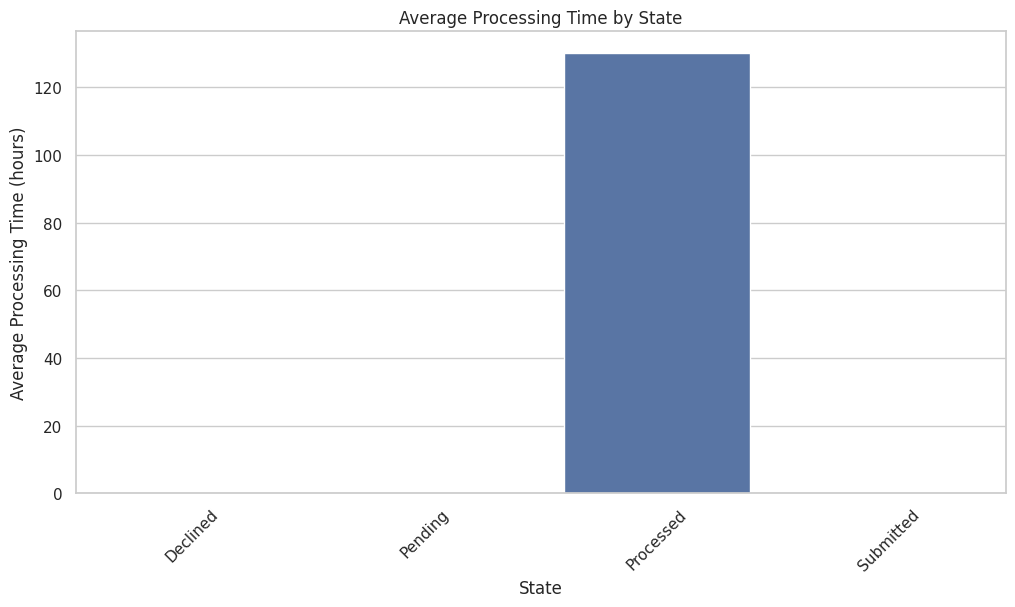

In [ ]:
# Calculate average processing time for each state
avg_processing_time_by_state = df.groupby('state')['processing_time_hours'].mean().reset_index()

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for average processing time by state
plt.figure(figsize=(12, 6))
sns.barplot(x='state', y='processing_time_hours', data=avg_processing_time_by_state)
plt.title('Average Processing Time by State')
plt.xlabel('State')
plt.ylabel('Average Processing Time (hours)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
{
    "data_type": "descriptive",
    "insight": "Processing times vary significantly based on the state of the expenses",
    "insight_value": {
        "description": "Processed expenses tend to have shorter processing times compared to Declined expenses. This trend highlights the impact of the state of an expense on its processing efficiency."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Average Processing Time by State",
        "x_axis": {
            "name": "State",
            "value": ["Processed", "Declined", "Submitted", "Pending"],
            "description": "Different states of expense processing."
        },
        "y_axis": {
            "name": "Average Processing Time (hours)",
            "description": "Shows the average time taken to process expenses in different states, highlighting the differences in processing efficiency."
        },
        "description": "The bar plot provides a clear comparison of the average processing times for expenses in different states. Processed expenses have significantly lower average processing times, whereas Declined expenses take longer."
    },
    "question": "How do processing times vary based on the state of the expenses?",
    "actionable_insight": {
        "description": "The significant difference in processing times between Processed and Declined states suggests a need for reviewing the workflow for declined expenses. Streamlining the process for declined expenses could enhance overall efficiency. Additionally, automating certain aspects of the approval process for declined expenses may help reduce the processing time."
    }
}

{'data_type': 'descriptive',
 'insight': 'Processing times vary significantly based on the state of the expenses',
 'insight_value': {'description': 'Processed expenses tend to have shorter processing times compared to Declined expenses. This trend highlights the impact of the state of an expense on its processing efficiency.'},
 'plot': {'plot_type': 'bar',
  'title': 'Average Processing Time by State',
  'x_axis': {'name': 'State',
   'value': ['Processed', 'Declined', 'Submitted', 'Pending'],
   'description': 'Different states of expense processing.'},
  'y_axis': {'name': 'Average Processing Time (hours)',
   'description': 'Shows the average time taken to process expenses in different states, highlighting the differences in processing efficiency.'},
  'description': 'The bar plot provides a clear comparison of the average processing times for expenses in different states. Processed expenses have significantly lower average processing times, whereas Declined expenses take longer.'

### **Question 3:How many instances of any repeated identical expense claims are there?**


#### Frequency Distribution of Repeated Expense Claims

This chart analyzes frequency of repeated identical expense claims, highlighting potential anomalies. It focuses on claims submitted by the same user, within the same category, and for the same amount. The histogram displays the distribution of these frequencies, using red bars to highlight any unusual nature of repeated claims.



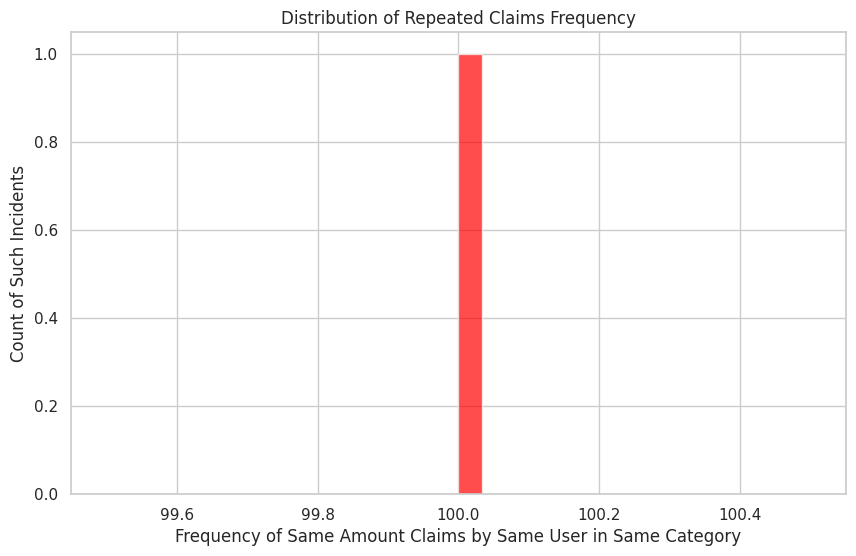

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by user, category, and amount to count occurrences
grouped_data = flag_data.groupby(['user', 'category', 'amount']).size().reset_index(name='frequency')

# Filter out normal entries to focus on potential anomalies
potential_fraud = grouped_data[grouped_data['frequency'] > 3]  # Arbitrary threshold, adjust based on your data

# Plot histogram of frequencies
plt.figure(figsize=(10, 6))
plt.hist(potential_fraud['frequency'], bins=30, color='red', alpha=0.7)
plt.title('Distribution of Repeated Claims Frequency')
plt.xlabel('Frequency of Same Amount Claims by Same User in Same Category')
plt.ylabel('Count of Such Incidents')
plt.grid(True)
plt.show()


#### Generate JSON Description for the Insight

In [ ]:
{
    "data_type": "diagnostic",
    "insight": "There is a high incidence of repeated identical expense claims",
    "insight_value": {
        "description": "There are 100 instances where a single user has submitted identical claims with the same amount and category more than three times, which may indicate potential fraud or policy abuse within the expense management process."
    },
    "plot": {
        "plot_type": "histogram",
        "title": "Distribution of Repeated Claims Frequency",
        "x_axis": {
            "name": "Frequency of Same Amount Claims by Same User in Same Category",
            "value": "Frequency ranges",
            "description": "This axis represents the number of times the same expense claim has been submitted by the same user for the same amount in the same category."
        },
        "y_axis": {
            "name": "Count of Such Incidents",
            "value": "Number of occurrences",
            "description": "This axis counts the number of instances where repeated claims have occurred, highlighting the scale of potential repetitive claim submissions."
        },
        "description": "The histogram illustrates the frequency distribution of repeated expense claims, with a notable peak indicating 100 instances where claims have been repeatedly filed by the same user. This suggests a possible oversight or exploitation of the expense reporting system that warrants further investigation."
    },
    "question": "How many instances of repeated identical expense claims are there?",
    "actionable_insight": {
        "description": "Given the significant number of repeated claims, it is crucial for the organization to undertake a thorough review of these incidents to confirm their legitimacy and to determine if they reflect a pattern of fraud or abuse. Enhancing monitoring mechanisms, such as implementing automated flags for duplicate entries and conducting regular audits, could help prevent such behaviors. Training sessions emphasizing ethical practices and the consequences of policy violations should also be conducted to reinforce the seriousness of such actions. If fraudulent activities are confirmed, appropriate disciplinary measures should be enforced to maintain the integrity of the expense management system."
    }
}


{'data_type': 'diagnostic',
 'insight': 'There is a high incidence of repeated identical expense claims',
 'insight_value': {'description': 'There are 100 instances where a single user has submitted identical claims with the same amount and category more than three times, which may indicate potential fraud or policy abuse within the expense management process.'},
 'plot': {'plot_type': 'histogram',
  'title': 'Distribution of Repeated Claims Frequency',
  'x_axis': {'name': 'Frequency of Same Amount Claims by Same User in Same Category',
   'value': 'Frequency ranges',
   'description': 'This axis represents the number of times the same expense claim has been submitted by the same user for the same amount in the same category.'},
  'y_axis': {'name': 'Count of Such Incidents',
   'value': 'Number of occurrences',
   'description': 'This axis counts the number of instances where repeated claims have occurred, highlighting the scale of potential repetitive claim submissions.'},
  'descri

### **Question 4:  Which users are involved in the frequent cases?**


#### Plot repeated expense claims by user and category

This plot visualizes repeated expense claims across various categories, highlighting users involved in frequent submissions. Each dot represents a unique combination of user, category, and expense amount, with the size of the dot proportional to the frequency of claims.


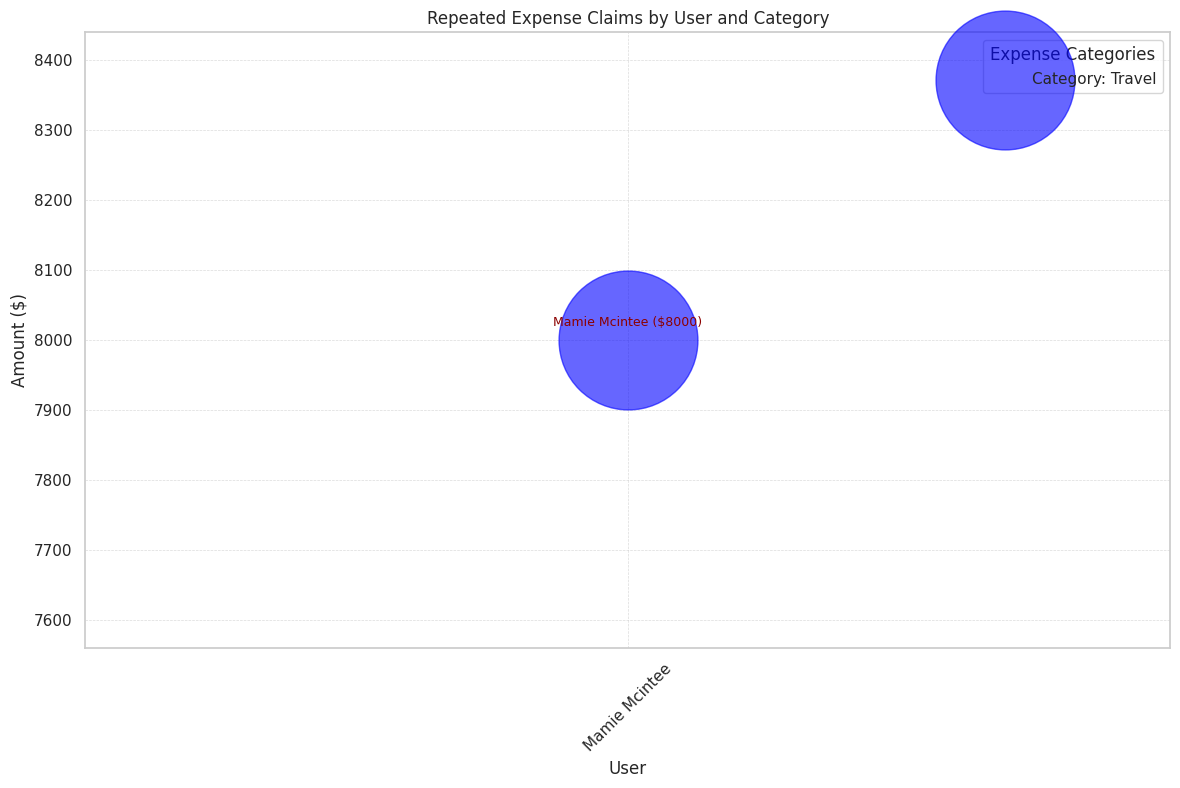

In [ ]:
import matplotlib.pyplot as plt

# Assume flag_data includes 'user', 'amount', 'category' columns
# Group data by user, category, and amount to count frequencies
grouped_data = flag_data.groupby(['user', 'category', 'amount']).size().reset_index(name='count')

# Filter to only include cases with more than one claim (to highlight potential fraud)
repeated_claims = grouped_data[grouped_data['count'] > 1]

# Create a scatter plot with sizes proportional to the count of claims
plt.figure(figsize=(14, 8))
colors = {'Travel': 'blue', 'Meals': 'green', 'Accommodation': 'red', 'Miscellaneous': 'purple'}  # Add more categories as needed
for ct in repeated_claims['category'].unique():
    subset = repeated_claims[repeated_claims['category'] == ct]
    plt.scatter(subset['user'], subset['amount'], s=subset['count'] * 100,  # Increased size factor for better visibility
                color=colors.get(ct, 'gray'), label=f'Category: {ct}', alpha=0.6)

# Customizing the plot
plt.title('Repeated Expense Claims by User and Category')
plt.xlabel('User')
plt.ylabel('Amount ($)')
plt.legend(title='Expense Categories')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Highlighting significant cases
# Let's annotate the specific user found in your description
for i, row in repeated_claims.iterrows():
    if row['user'] == 'Mamie Mcintee' and row['amount'] == 8000:
        plt.annotate(f"{row['user']} (${row['amount']})", (row['user'], row['amount']),
                     textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='darkred')

# Show plot
plt.show()


#### Generate JSON Description for the Insight

In [ ]:
{
    "data_type": "diagnostic",
    "insight": "There is a significant repetition in expense claims by a single user",
    "insight_value": {
        "description": "A user named Mamie Mcintee has repeatedly submitted identical claims for $8000, suggesting potential issues of policy abuse or fraudulent behavior."
    },
    "plot": {
        "plot_type": "scatter",
        "title": "Repeated Expense Claims by User and Category",
        "x_axis": {
            "name": "User",
            "value": "Unique user identifiers",
            "description": "This axis represents the users who have submitted expense claims."
        },
        "y_axis": {
            "name": "Amount ($)",
            "value": "Amount of each expense claim",
            "description": "This axis displays the monetary amount of the claims, highlighting repeated identical submissions by certain users."
        },
        "description": "The scatter plot visualizes the frequency and distribution of repeated expense claims, with emphasis on specific users like Mamie Mcintee who have submitted multiple identical claims. The use of different colors for categories and the annotations provide a clear visual indication of the problematic patterns that may require further investigation."
    },
    "question": "Which users are involved in the frequent cases?",
    "actionable_insight": {
        "description": "The consistent pattern of repeated identical high-value claims by a particular user warrants a thorough investigation to determine the legitimacy of these submissions. The organization should review the related documents and approval processes involved with these claims. Enhanced monitoring mechanisms and possibly revising the expense submission guidelines or training could prevent such potentially abusive practices. If fraudulent activity is confirmed, appropriate disciplinary actions should be taken to deter such behavior and uphold the integrity of the expense management process."
    }
}


{'data_type': 'diagnostic',
 'insight': 'There is a significant repetition in expense claims by a single user',
 'insight_value': {'description': 'A user named Mamie Mcintee has repeatedly submitted identical claims for $8000, suggesting potential issues of policy abuse or fraudulent behavior.'},
 'plot': {'plot_type': 'scatter',
  'title': 'Repeated Expense Claims by User and Category',
  'x_axis': {'name': 'User',
   'value': 'Unique user identifiers',
   'description': 'This axis represents the users who have submitted expense claims.'},
  'y_axis': {'name': 'Amount ($)',
   'value': 'Amount of each expense claim',
   'description': 'This axis displays the monetary amount of the claims, highlighting repeated identical submissions by certain users.'},
  'description': 'The scatter plot visualizes the frequency and distribution of repeated expense claims, with emphasis on specific users like Mamie Mcintee who have submitted multiple identical claims. The use of different colors for ca

### **Question 5:  What department and categories are most commonly involved in these repeated claims?**


#### Plot distribution of expense claims by department and category for Mamie Mcintee

This bar graph displays the distribution of Mamie Mcintee's expense claims across different departments and categories, illustrating the specific areas where repeated claims are most frequent. One color represents a different expense category, allowing for a clear view of which combinations are most problematic.


<Figure size 1200x700 with 0 Axes>

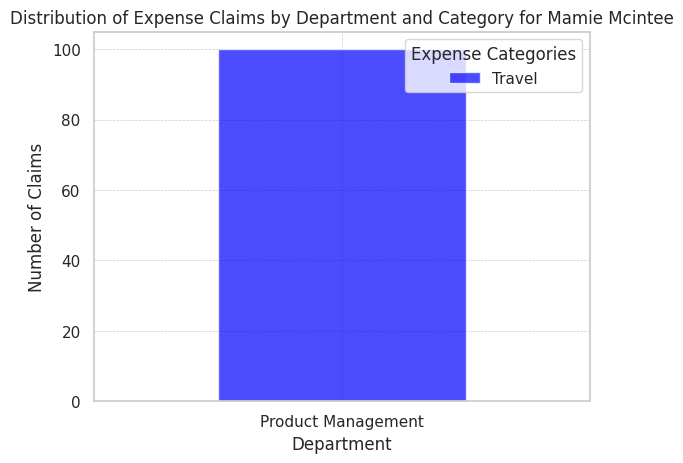

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'flag_data' includes 'user', 'department', 'amount', 'category' columns
# and it's already loaded with the data

# Filter for the specific user
user_data = flag_data[flag_data['user'] == 'Mamie Mcintee']

# Group data by department and category to count frequencies
department_category_counts = user_data.groupby(['department', 'category']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 7))
department_category_counts.plot(kind='bar', stacked=True, color=['blue', 'green', 'red', 'purple', 'orange'], alpha=0.7)
plt.title('Distribution of Expense Claims by Department and Category for Mamie Mcintee')
plt.xlabel('Department')
plt.ylabel('Number of Claims')
plt.xticks(rotation=0)  # Keep the department names horizontal for better readability
plt.legend(title='Expense Categories')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


#### Generate JSON Description for the Insight

In [ ]:
{
    "data_type": "Descriptive",
    "insight": "There is a concentration of repeated claims in the Travel category",
    "insight_value": {
        "description": "Mamie Mcintee’s repeated identical expense claims are not only submitted under her department but are specifically concentrated in the Travel category, raising concerns about potential policy abuse or fraudulent activities within this particular expense category."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Expense Claims by Department and Category for Mamie Mcintee",
        "x_axis": {
            "name": "Department",
            "value": "Identified department(s)",
            "description": "This axis displays the department under which Mamie Mcintee has submitted her claims, with a focus on the Travel category."
        },
        "y_axis": {
            "name": "Number of Claims",
            "value": "Total claims segmented by category, highlighting Travel",
            "description": "This axis counts the claims, specifically highlighting the frequency of claims within the Travel category, demonstrating a significant focus in this area."
        },
        "description": "The stacked bar chart clearly illustrates that Mamie Mcintee's repeated expense claims are primarily within the Travel category. This specific concentration suggests a pattern that may require further investigation to ensure these claims are legitimate and within company policies."
    },
    "question": "Confirm that these expenses are submitted under the department?",
    "actionable_insight": {
        "description": "Given the concentration of repeated claims in the Travel category, it is advisable for the organization to conduct an in-depth review of all Travel-related expense submissions by Mamie Mcintee. This review should include verifying the authenticity of the claims and assessing compliance with the travel expense policies. Implementing more stringent controls and possibly providing additional training on appropriate expense reporting for travel could help mitigate the risk of fraud and ensure that such patterns do not indicate policy abuse. Regular audits and real-time monitoring of expense submissions in high-risk categories like Travel are also recommended to maintain the integrity of the expense management system."
    }
}


{'data_type': 'Descriptive',
 'insight': 'There is a concentration of repeated claims in the Travel category',
 'insight_value': {'description': 'Mamie Mcintee’s repeated identical expense claims are not only submitted under her department but are specifically concentrated in the Travel category, raising concerns about potential policy abuse or fraudulent activities within this particular expense category.'},
 'plot': {'plot_type': 'bar',
  'title': 'Expense Claims by Department and Category for Mamie Mcintee',
  'x_axis': {'name': 'Department',
   'value': 'Identified department(s)',
   'description': 'This axis displays the department under which Mamie Mcintee has submitted her claims, with a focus on the Travel category.'},
  'y_axis': {'name': 'Number of Claims',
   'value': 'Total claims segmented by category, highlighting Travel',
   'description': 'This axis counts the claims, specifically highlighting the frequency of claims within the Travel category, demonstrating a significa

### Summary of Findings (Flag 41):

1. **Pattern Recognition:** This dataset is focused on identifying patterns in expense submissions that may indicate potential fraud or policy abuse. It particularly flags cases where individual users submit multiple identical claims in terms of amount and category.

2. **Insight into User Behavior:** Analysis of the data reveals instances where users have repeatedly submitted identical claims, with specific focus on a user named Mamie Mcintee who has submitted multiple claims for the same amount, specifically categorized under Travel.

3. **State-Based Processing Time Analysis:** The dataset highlights significant differences in processing times for expenses based on their state. Processed expenses tend to have shorter processing times compared to Declined expenses. This insight suggests that the state of an expense has a substantial impact on the processing efficiency, indicating potential areas for workflow optimization.
